In [18]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import polars as pl
import xgboost as xgb
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import warnings

# Suppress warnings globally
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
from collections import Counter
import numpy as np
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [19]:
def get_train_test(df, test_size):
    # Make X and Y dataset
    y = df.observation
    print(y.unique())
    X = df.loc[:,'VH_30':'VH_0']
    X['nth'] = df.loc[:,'nth']
    X['nth'] = X.nth.astype('category')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234, stratify=y)
    return X_train, X_test, y_train, y_test

In [20]:
def akurasi_kelas_generatif(y_true, y_pred):
    # Calculate accuracy specifically for class 3
    class_3_mask = (y_true == 3)
    if np.any(class_3_mask):  # Check if class 3 is present in the true labels
        return accuracy_score(y_true[class_3_mask], y_pred[class_3_mask])
    else:
        return 0.0  # Return 0 if class 3 is not present in the true labels

def akurasi_fase_padi(y_true, y_pred):
    # Calculate accuracy specifically for classes 1, 2, 3, and 4
    class_1234_mask = (y_true >= 1) & (y_true <= 4)
    if np.any(class_1234_mask):  # Check if classes 1,2,3,4 are present in the true labels
        return accuracy_score(y_true[class_1234_mask], y_pred[class_1234_mask])
    else:
        return 0.0  # Return 0 if none of the classes 0-3 are present in the true labels

In [21]:
kdprov='53'

In [22]:
# Parameters
kdprov = 53


In [23]:
## Read VH dataset
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/training_VH_v2.pkl','rb') as file:
    df=pickle.load(file)
    if isinstance(df, pl.DataFrame):
        df=df.to_pandas()
print(df.shape)
df.head()

(507905, 44)


,idpoint,idsubsegment,idsegment,nth,periode,observation,class,MGRS,VH_30,VH_29,...,VH_4,VH_3,VH_2,VH_1,VH_0,idkabkota,cluster_data,Sigma0VH_variance,winner,prior
0,530203005A3#03,530203005A3,530203005,1,2022_03,6,NP,51LTJ,-15.003157,-14.839792,...,-13.897276,-14.796861,-14.661230,-15.619116,-14.951990,5302,0,0.829796,R1C13,0.528853
2,530203005A3#09,530203005A3,530203005,1,2022_03,6,NP,51LTJ,-14.024279,-15.679726,...,-13.819187,-14.062122,-13.394154,-15.788738,-13.603525,5302,0,0.829796,R1C13,0.528853
6,530203005A3#10,530203005A3,530203005,1,2022_03,6,NP,51LTJ,-13.940150,-15.205002,...,-14.051441,-13.974236,-12.852287,-15.443974,-13.848682,5302,0,0.829796,R10C3,0.580280
8,530203005A3#16,530203005A3,530203005,1,2022_03,6,NP,51LTJ,-13.811125,-13.073202,...,-13.449095,-13.657732,-13.136038,-13.469506,-13.738852,5302,0,0.829796,R14C14,0.510204
10,530203005A3#18,530203005A3,530203005,1,2022_03,6,NP,51LTJ,-13.002995,-13.710638,...,-12.984497,-12.618353,-11.922312,-12.557711,-12.023638,5302,0,0.829796,R11C12,0.612252


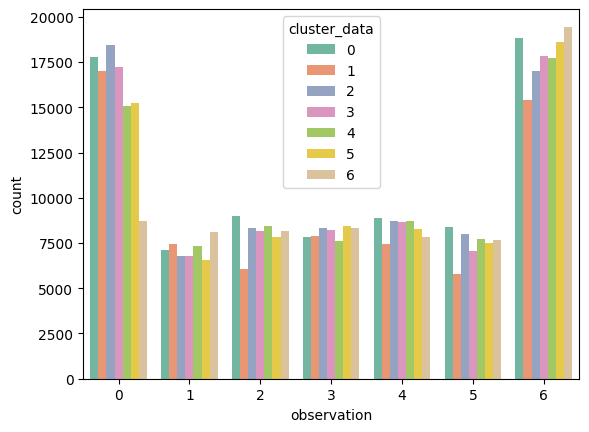

In [24]:
sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))
plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distirbution_plot.png", dpi=300, bbox_inches='tight')

### Running Data

In [25]:
import optuna
from xgboost import XGBClassifier

# Example dataset

# Define the objective function for Bayesian Optimization
def objective(trial,X_train, y_train, n_splits=3):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        #'subsample': trial.suggest_uniform('subsample', 0.5, 0.7),
        #'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.7),
        #'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 0.7),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.1, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 50, 100),
        'objective': 'multi:softprob',  # Multiclass classification
        'eval_metric': ['mlogloss'],
        "tree_method":'hist',
        "num_class": len(set(y_train)),
        "nthread":20
    }
    
    # Define the model
    skf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=42)
    f1_macros=[]
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(param, dtrain_fold, 
                          num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                          verbose_eval=False)
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
    score=np.mean(f1_macros)
    
    return score

In [26]:
def evaluate_model(X_train, y_train, X_test, y_test,cluster, best_params, n_splits=3):
    # Convert data to DMatrix for XGBoost
    class_counts = Counter(y_train)
    total_samples = len(y_train)
        # Step 3: Calculate class weights as inverse of class frequency
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    sample_weights = np.array([class_weights[label] for label in y_train])
        # Create DMatrix with sample weights
        
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True,weight=sample_weights)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
    
    params = best_params
    params['objective']="multi:softprob"
    #params['tree_method']='approx'
    params['eval_metric']='mlogloss'
    params['num_class']=len(set(y_train))
    params['nthread']=20
    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    accuracies = []
    f1_macros = []
    f1_micros = []
    aucs = []
    acc_kelas_generatifs = []
    acc_fase_padis = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(params, dtrain_fold, 
                          num_boost_round=10000, evals=evals,early_stopping_rounds=1000,verbose_eval=100)
        
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        
        accuracies.append(accuracy_score(y_val_fold, y_val_pred))
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
        f1_micros.append(f1_score(y_val_fold, y_val_pred, average='micro'))
        aucs.append(roc_auc_score(y_val_fold, y_val_pred_prob, multi_class='ovr'))
        acc_kelas_generatifs.append(akurasi_kelas_generatif(y_val_fold, y_val_pred))
        acc_fase_padis.append(akurasi_fase_padi(y_val_fold, y_val_pred))

    # Calculate average metrics
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_f1_macro = sum(f1_macros) / len(f1_macros)
    avg_f1_micro = sum(f1_micros) / len(f1_micros)
    avg_auc = sum(aucs) / len(aucs)
    avg_acc_kelas_generatif = sum(acc_kelas_generatifs) / len(acc_kelas_generatifs)
    avg_acc_fase_padi = sum(acc_fase_padis) / len(acc_fase_padis)
    training_metrics = {
        "average_accuracy": avg_accuracy,
        "average_f1_macro": avg_f1_macro,
        "average_f1_micro": avg_f1_micro,
        "average_auc": avg_auc,
        "average_acc_kelas_generatif": avg_acc_kelas_generatif,
        "average_acc_fase_padi": avg_acc_fase_padi
    }

    
    # Final model evaluation on the test set
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    model = xgb.train(params, dtrain, 
                      num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                      verbose_eval=50)
    y_test_pred_prob = model.predict(dtest)
    y_test_pred = y_test_pred_prob.argmax(axis=1)

    accuracy = accuracy_score(y_test, y_test_pred)
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_micro = f1_score(y_test, y_test_pred, average='micro')
    auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')
    acc_kelas_generatif = akurasi_kelas_generatif(y_test, y_test_pred)
    acc_fase_padi = akurasi_fase_padi(y_test, y_test_pred)
    
    cm = confusion_matrix(y_test, y_test_pred)
    relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    validation_metrics = {
        "val_accuracy": accuracy,
        "val_f1_macro": f1_macro,
        "val_f1_micro": f1_micro,
        "val_auc": auc,
        "val_acc_kelas_generatif": acc_kelas_generatif,
        "val_acc_fase_padi": acc_fase_padi,
        "val_relative_acc": relative_acc
    }

    print("\nClassification Report on Test Set:")
    report = classification_report(y_test, y_test_pred)
    print(report)
    
    # Display Confusion Matrix
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_cm_cluster_{cluster}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, training_metrics, validation_metrics, report, cm

CLUSTER:  0


[I 2024-10-29 08:16:58,799] A new study created in memory with name: no-name-40d0137a-3c50-4518-930d-0b30ccb1b4d2


[6 4 1 5 2 0 3]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-29 08:17:39,542] Trial 0 finished with value: 0.6926276663794879 and parameters: {'max_depth': 6, 'learning_rate': 0.048620675418136895, 'reg_lambda': 4.636004750839269, 'min_child_weight': 60}. Best is trial 0 with value: 0.6926276663794879.
[I 2024-10-29 08:18:46,947] Trial 1 finished with value: 0.6965797938833088 and parameters: {'max_depth': 10, 'learning_rate': 0.026714607029000692, 'reg_lambda': 4.494339027599392, 'min_child_weight': 83}. Best is trial 1 with value: 0.6965797938833088.
[I 2024-10-29 08:19:30,002] Trial 2 finished with value: 0.6920846634920778 and parameters: {'max_depth': 6, 'learning_rate': 0.04538166223697139, 'reg_lambda': 0.5884281659782467, 'min_child_weight': 76}. Best is trial 1 with value: 0.6965797938833088.
[I 2024-10-29 08:20:13,667] Trial 3 finished with value: 0.697667320302263 and parameters: {'max_depth': 9, 'learning_rate': 0.042831779162326236, 'reg_lambda': 2.489922263378044, 'min_child_weight': 57}. Best is trial 3 with value: 0.69

Best Parameters: {'max_depth': 9, 'learning_rate': 0.042831779162326236, 'reg_lambda': 2.489922263378044, 'min_child_weight': 57}
Best Score: 0.697667320302263
Start the modelling
[0]	train-mlogloss:1.87541	eval-mlogloss:1.88394
[100]	train-mlogloss:0.47912	eval-mlogloss:0.84709
[200]	train-mlogloss:0.31874	eval-mlogloss:0.79859
[300]	train-mlogloss:0.23674	eval-mlogloss:0.78551
[400]	train-mlogloss:0.17484	eval-mlogloss:0.78077
[500]	train-mlogloss:0.13315	eval-mlogloss:0.78184
[600]	train-mlogloss:0.10459	eval-mlogloss:0.78542
[700]	train-mlogloss:0.08371	eval-mlogloss:0.79156
[800]	train-mlogloss:0.06980	eval-mlogloss:0.79819
[900]	train-mlogloss:0.05942	eval-mlogloss:0.80517
[1000]	train-mlogloss:0.05145	eval-mlogloss:0.81272
[1100]	train-mlogloss:0.04532	eval-mlogloss:0.82055
[1200]	train-mlogloss:0.04007	eval-mlogloss:0.82821
[1300]	train-mlogloss:0.03599	eval-mlogloss:0.83554
[1400]	train-mlogloss:0.03261	eval-mlogloss:0.84245
[1446]	train-mlogloss:0.03119	eval-mlogloss:0.84603


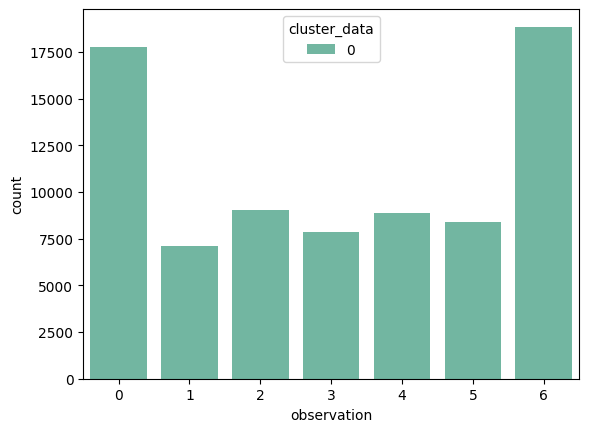

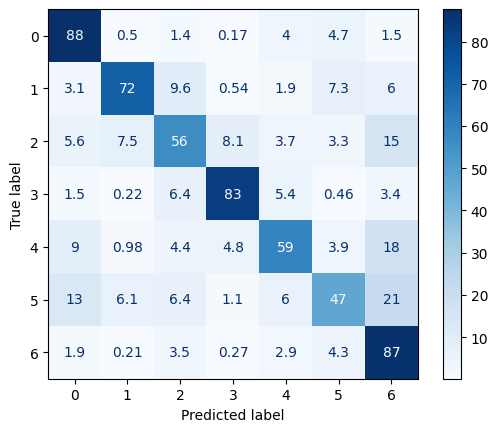

{'average_accuracy': 0.7351140790205899, 'average_f1_macro': np.float64(0.6997269725436405), 'average_f1_micro': np.float64(0.7351140790205899), 'average_auc': np.float64(0.9295883549182129), 'average_acc_kelas_generatif': 0.8380102040816326, 'average_acc_fase_padi': 0.650872773906983}
{'val_accuracy': 0.7419467273260933, 'val_f1_macro': np.float64(0.7091789001560199), 'val_f1_micro': np.float64(0.7419467273260933), 'val_auc': np.float64(0.9353235529443097), 'val_acc_kelas_generatif': 0.8263483965014577, 'val_acc_fase_padi': 0.6664782362916902, 'val_relative_acc': np.float64(94.08720403674472)}
CLUSTER:  1


[I 2024-10-29 08:23:21,916] A new study created in memory with name: no-name-8a23bb1e-07c5-4267-80b1-97092dee464e


[6 1 5 0 4 2 3]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-29 08:23:52,782] Trial 0 finished with value: 0.7461932577253486 and parameters: {'max_depth': 10, 'learning_rate': 0.07290817018105171, 'reg_lambda': 3.8432904364572233, 'min_child_weight': 96}. Best is trial 0 with value: 0.7461932577253486.
[I 2024-10-29 08:24:18,918] Trial 1 finished with value: 0.7464511688247194 and parameters: {'max_depth': 9, 'learning_rate': 0.06836170908839892, 'reg_lambda': 1.7617922533720953, 'min_child_weight': 54}. Best is trial 1 with value: 0.7464511688247194.
[I 2024-10-29 08:24:56,472] Trial 2 finished with value: 0.7438374305290368 and parameters: {'max_depth': 7, 'learning_rate': 0.04799386465552074, 'reg_lambda': 2.7296181766929335, 'min_child_weight': 63}. Best is trial 1 with value: 0.7464511688247194.
[I 2024-10-29 08:25:45,524] Trial 3 finished with value: 0.7452593531057756 and parameters: {'max_depth': 8, 'learning_rate': 0.037538507892356306, 'reg_lambda': 3.6164403114976955, 'min_child_weight': 54}. Best is trial 1 with value: 0.

Best Parameters: {'max_depth': 9, 'learning_rate': 0.06836170908839892, 'reg_lambda': 1.7617922533720953, 'min_child_weight': 54}
Best Score: 0.7464511688247194
Start the modelling
[0]	train-mlogloss:1.81750	eval-mlogloss:1.82949
[100]	train-mlogloss:0.29313	eval-mlogloss:0.65587
[200]	train-mlogloss:0.16107	eval-mlogloss:0.61549
[300]	train-mlogloss:0.09849	eval-mlogloss:0.60739
[400]	train-mlogloss:0.06804	eval-mlogloss:0.61072
[500]	train-mlogloss:0.05065	eval-mlogloss:0.61692
[600]	train-mlogloss:0.03986	eval-mlogloss:0.62394
[700]	train-mlogloss:0.03249	eval-mlogloss:0.63120
[800]	train-mlogloss:0.02736	eval-mlogloss:0.63910
[900]	train-mlogloss:0.02358	eval-mlogloss:0.64673
[1000]	train-mlogloss:0.02073	eval-mlogloss:0.65420
[1100]	train-mlogloss:0.01855	eval-mlogloss:0.66067
[1200]	train-mlogloss:0.01682	eval-mlogloss:0.66614
[1300]	train-mlogloss:0.01544	eval-mlogloss:0.67105
[1332]	train-mlogloss:0.01504	eval-mlogloss:0.67275
[0]	train-mlogloss:1.81739	eval-mlogloss:1.83075
[1

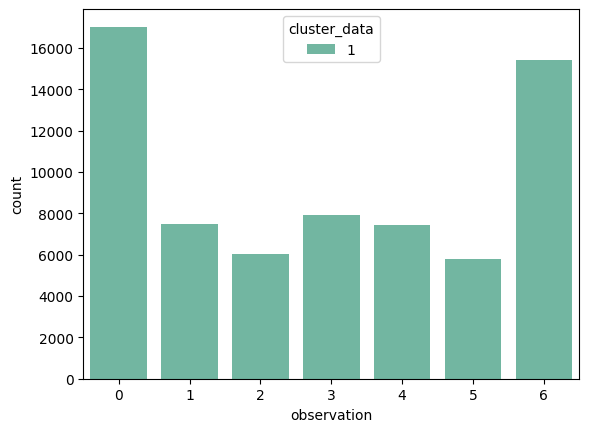

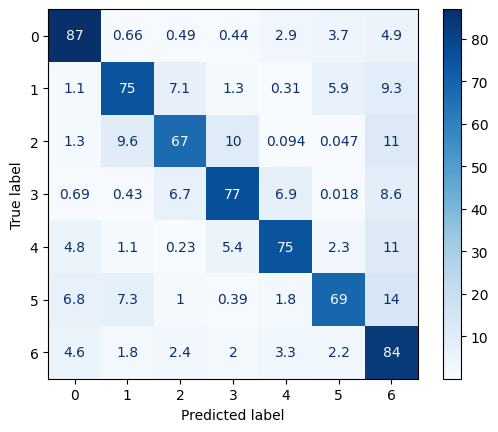

{'average_accuracy': 0.7769716556286684, 'average_f1_macro': np.float64(0.7502056959459623), 'average_f1_micro': np.float64(0.7769716556286684), 'average_auc': np.float64(0.9634051152196278), 'average_acc_kelas_generatif': 0.7425200168563001, 'average_acc_fase_padi': 0.7067590987868284}
{'val_accuracy': 0.7898501362397821, 'val_f1_macro': np.float64(0.7678007691174946), 'val_f1_micro': np.float64(0.7898501362397821), 'val_auc': np.float64(0.9687218152016747), 'val_acc_kelas_generatif': 0.7660765895953757, 'val_acc_fase_padi': 0.737657836098044, 'val_relative_acc': np.float64(98.86147103658537)}
CLUSTER:  2


[I 2024-10-29 08:28:37,530] A new study created in memory with name: no-name-beb5c547-9245-42c1-bd46-de72826b4c1f


[1 2 6 5 4 0 3]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-29 08:29:20,884] Trial 0 finished with value: 0.7410754475259799 and parameters: {'max_depth': 8, 'learning_rate': 0.036961923183853336, 'reg_lambda': 3.646616660198768, 'min_child_weight': 85}. Best is trial 0 with value: 0.7410754475259799.
[I 2024-10-29 08:29:46,474] Trial 1 finished with value: 0.7396988947297904 and parameters: {'max_depth': 8, 'learning_rate': 0.07079628075298053, 'reg_lambda': 1.71303592892703, 'min_child_weight': 99}. Best is trial 0 with value: 0.7410754475259799.
[I 2024-10-29 08:30:05,730] Trial 2 finished with value: 0.7430718203227276 and parameters: {'max_depth': 8, 'learning_rate': 0.08986559249539314, 'reg_lambda': 3.4656924836231284, 'min_child_weight': 50}. Best is trial 2 with value: 0.7430718203227276.
[I 2024-10-29 08:30:57,112] Trial 3 finished with value: 0.7423561718423413 and parameters: {'max_depth': 8, 'learning_rate': 0.03063213241180001, 'reg_lambda': 4.105529283232557, 'min_child_weight': 80}. Best is trial 2 with value: 0.74307

Best Parameters: {'max_depth': 8, 'learning_rate': 0.08986559249539314, 'reg_lambda': 3.4656924836231284, 'min_child_weight': 50}
Best Score: 0.7430718203227276
Start the modelling
[0]	train-mlogloss:1.78404	eval-mlogloss:1.79824
[100]	train-mlogloss:0.30392	eval-mlogloss:0.70010
[200]	train-mlogloss:0.15794	eval-mlogloss:0.69037
[300]	train-mlogloss:0.09224	eval-mlogloss:0.70126
[400]	train-mlogloss:0.05970	eval-mlogloss:0.72155
[500]	train-mlogloss:0.04341	eval-mlogloss:0.74183
[600]	train-mlogloss:0.03363	eval-mlogloss:0.75927
[700]	train-mlogloss:0.02724	eval-mlogloss:0.77581
[800]	train-mlogloss:0.02277	eval-mlogloss:0.79190
[900]	train-mlogloss:0.01953	eval-mlogloss:0.80570
[1000]	train-mlogloss:0.01716	eval-mlogloss:0.81798
[1100]	train-mlogloss:0.01530	eval-mlogloss:0.82902
[1179]	train-mlogloss:0.01410	eval-mlogloss:0.83688
[0]	train-mlogloss:1.78559	eval-mlogloss:1.79723
[100]	train-mlogloss:0.31268	eval-mlogloss:0.67744
[200]	train-mlogloss:0.16306	eval-mlogloss:0.65979
[300

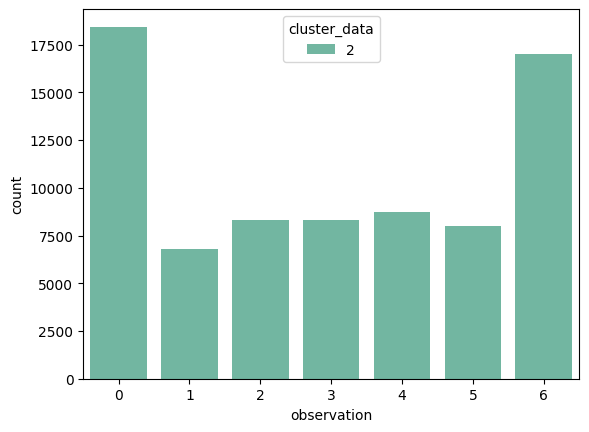

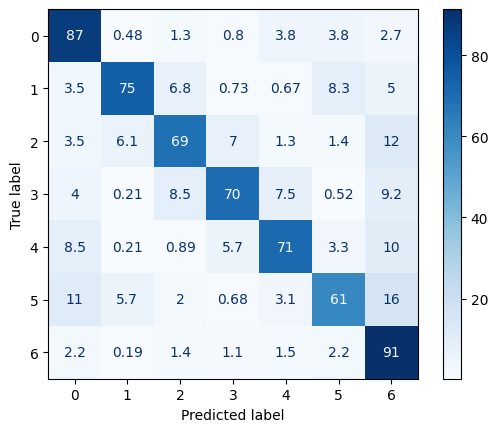

{'average_accuracy': 0.7741708135923006, 'average_f1_macro': np.float64(0.7461404350620621), 'average_f1_micro': np.float64(0.7741708135923006), 'average_auc': np.float64(0.945910787776385), 'average_acc_kelas_generatif': 0.6728209178006109, 'average_acc_fase_padi': 0.6885432866770348}
{'val_accuracy': 0.7849797739215909, 'val_f1_macro': np.float64(0.7605858654737521), 'val_f1_micro': np.float64(0.7849797739215909), 'val_auc': np.float64(0.9560348161112174), 'val_acc_kelas_generatif': 0.7011000343760743, 'val_acc_fase_padi': 0.7108642523883582, 'val_relative_acc': np.float64(97.93889531645027)}
CLUSTER:  3


[I 2024-10-29 08:33:49,188] A new study created in memory with name: no-name-160a92cb-187b-463c-924e-6661c24b05fb


[1 4 2 6 5 0 3]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-29 08:34:24,645] Trial 0 finished with value: 0.7343495098636043 and parameters: {'max_depth': 6, 'learning_rate': 0.06362751002402822, 'reg_lambda': 2.7766936521210774, 'min_child_weight': 93}. Best is trial 0 with value: 0.7343495098636043.
[I 2024-10-29 08:34:57,702] Trial 1 finished with value: 0.7404728568024582 and parameters: {'max_depth': 9, 'learning_rate': 0.05870514592820447, 'reg_lambda': 4.323925955223324, 'min_child_weight': 79}. Best is trial 1 with value: 0.7404728568024582.
[I 2024-10-29 08:35:41,983] Trial 2 finished with value: 0.7417298837247294 and parameters: {'max_depth': 10, 'learning_rate': 0.04429650617916862, 'reg_lambda': 3.760200758736192, 'min_child_weight': 78}. Best is trial 2 with value: 0.7417298837247294.
[I 2024-10-29 08:36:53,514] Trial 3 finished with value: 0.7420610748328693 and parameters: {'max_depth': 10, 'learning_rate': 0.029545696305835062, 'reg_lambda': 3.2218936281794357, 'min_child_weight': 71}. Best is trial 3 with value: 0.7

Best Parameters: {'max_depth': 10, 'learning_rate': 0.029545696305835062, 'reg_lambda': 3.2218936281794357, 'min_child_weight': 71}
Best Score: 0.7420610748328693
Start the modelling
[0]	train-mlogloss:1.89541	eval-mlogloss:1.90101
[100]	train-mlogloss:0.53466	eval-mlogloss:0.83210
[200]	train-mlogloss:0.32370	eval-mlogloss:0.73133
[300]	train-mlogloss:0.24274	eval-mlogloss:0.70746
[400]	train-mlogloss:0.19103	eval-mlogloss:0.69719
[500]	train-mlogloss:0.15368	eval-mlogloss:0.69270
[600]	train-mlogloss:0.12578	eval-mlogloss:0.69192
[700]	train-mlogloss:0.10443	eval-mlogloss:0.69210
[800]	train-mlogloss:0.08924	eval-mlogloss:0.69427
[900]	train-mlogloss:0.07700	eval-mlogloss:0.69722
[1000]	train-mlogloss:0.06687	eval-mlogloss:0.70086
[1100]	train-mlogloss:0.05929	eval-mlogloss:0.70444
[1200]	train-mlogloss:0.05329	eval-mlogloss:0.70819
[1300]	train-mlogloss:0.04829	eval-mlogloss:0.71268
[1400]	train-mlogloss:0.04398	eval-mlogloss:0.71680
[1500]	train-mlogloss:0.04041	eval-mlogloss:0.721

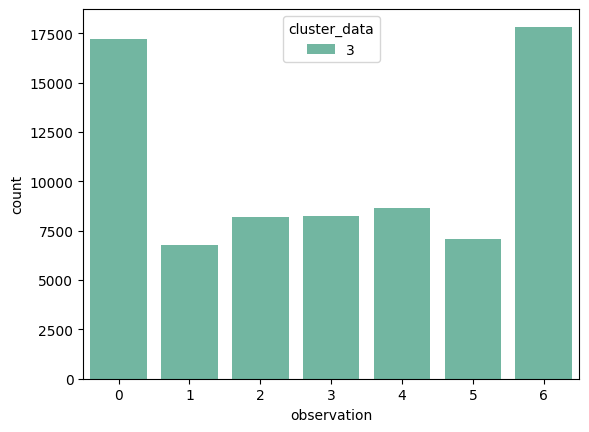

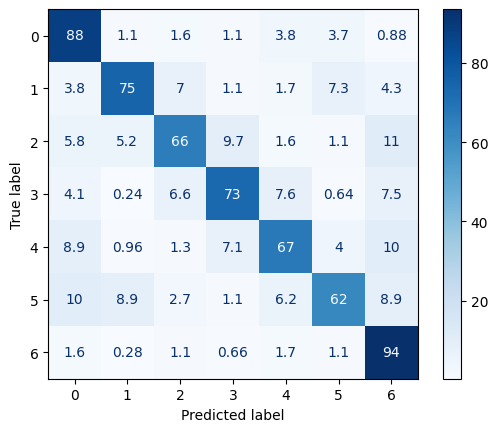

{'average_accuracy': 0.7819463706747286, 'average_f1_macro': np.float64(0.7467653130899237), 'average_f1_micro': np.float64(0.7819463706747286), 'average_auc': np.float64(0.9499014877548139), 'average_acc_kelas_generatif': 0.7283049472830495, 'average_acc_fase_padi': 0.6877495722933444}
{'val_accuracy': 0.7911457226226594, 'val_f1_macro': np.float64(0.7585217598655909), 'val_f1_micro': np.float64(0.7911457226226594), 'val_auc': np.float64(0.9565362742999459), 'val_acc_kelas_generatif': 0.7342718109141467, 'val_acc_fase_padi': 0.7004711689477227, 'val_relative_acc': np.float64(97.13914737069898)}
CLUSTER:  4


[I 2024-10-29 08:40:41,730] A new study created in memory with name: no-name-262db5e5-9240-4488-939b-e63763ccb4ee


[1 6 5 4 3 2 0]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-29 08:41:11,142] Trial 0 finished with value: 0.7833567318944525 and parameters: {'max_depth': 6, 'learning_rate': 0.06336567863400282, 'reg_lambda': 3.7235836234038358, 'min_child_weight': 69}. Best is trial 0 with value: 0.7833567318944525.
[I 2024-10-29 08:42:13,650] Trial 1 finished with value: 0.7738411512385411 and parameters: {'max_depth': 7, 'learning_rate': 0.011457249777812597, 'reg_lambda': 4.690598089863691, 'min_child_weight': 89}. Best is trial 0 with value: 0.7833567318944525.
[I 2024-10-29 08:42:43,038] Trial 2 finished with value: 0.7843225754203317 and parameters: {'max_depth': 9, 'learning_rate': 0.0602557432501269, 'reg_lambda': 3.9045077980286376, 'min_child_weight': 92}. Best is trial 2 with value: 0.7843225754203317.
[I 2024-10-29 08:43:19,149] Trial 3 finished with value: 0.7850399102585883 and parameters: {'max_depth': 8, 'learning_rate': 0.04345088358058486, 'reg_lambda': 2.7411402478119733, 'min_child_weight': 64}. Best is trial 3 with value: 0.785

Best Parameters: {'max_depth': 8, 'learning_rate': 0.04345088358058486, 'reg_lambda': 2.7411402478119733, 'min_child_weight': 64}
Best Score: 0.7850399102585883
Start the modelling
[0]	train-mlogloss:1.86655	eval-mlogloss:1.87238
[100]	train-mlogloss:0.43011	eval-mlogloss:0.64303
[200]	train-mlogloss:0.28511	eval-mlogloss:0.57334
[300]	train-mlogloss:0.20744	eval-mlogloss:0.55146
[400]	train-mlogloss:0.15448	eval-mlogloss:0.54224
[500]	train-mlogloss:0.11778	eval-mlogloss:0.53892
[600]	train-mlogloss:0.09101	eval-mlogloss:0.53906
[700]	train-mlogloss:0.07323	eval-mlogloss:0.54267
[800]	train-mlogloss:0.06092	eval-mlogloss:0.54673
[900]	train-mlogloss:0.05155	eval-mlogloss:0.55142
[1000]	train-mlogloss:0.04483	eval-mlogloss:0.55634
[1100]	train-mlogloss:0.03912	eval-mlogloss:0.56098
[1200]	train-mlogloss:0.03450	eval-mlogloss:0.56575
[1300]	train-mlogloss:0.03113	eval-mlogloss:0.57059
[1400]	train-mlogloss:0.02815	eval-mlogloss:0.57591
[1500]	train-mlogloss:0.02575	eval-mlogloss:0.58044

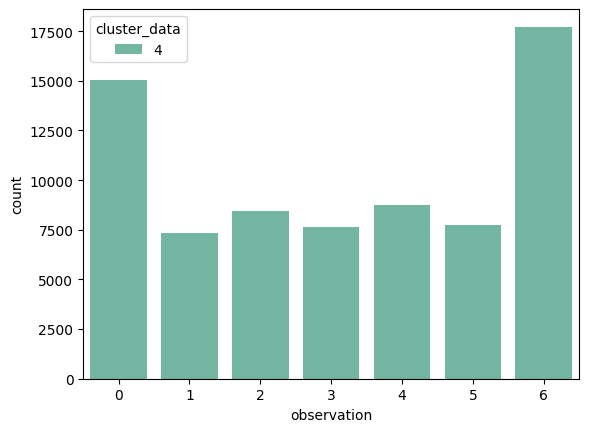

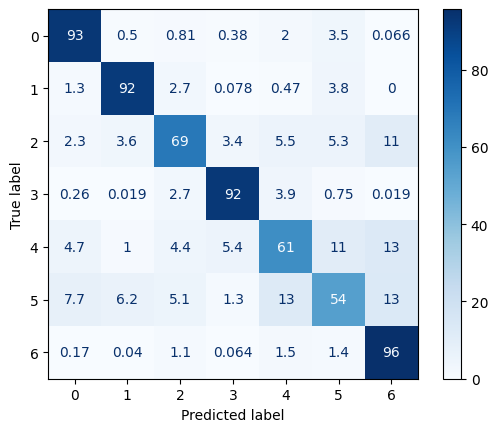

{'average_accuracy': 0.8185654008438817, 'average_f1_macro': np.float64(0.7880129137372025), 'average_f1_micro': np.float64(0.8185654008438817), 'average_auc': np.float64(0.9581271156615773), 'average_acc_kelas_generatif': 0.9175061013405794, 'average_acc_fase_padi': 0.7648706008863567}
{'val_accuracy': 0.8264014466546112, 'val_f1_macro': np.float64(0.7981568391173138), 'val_f1_micro': np.float64(0.8264014466546112), 'val_auc': np.float64(0.9629248369573293), 'val_acc_kelas_generatif': 0.9234655688622755, 'val_acc_fase_padi': 0.7757050854985565, 'val_relative_acc': np.float64(94.4417651314203)}
CLUSTER:  5


[I 2024-10-29 08:46:20,168] A new study created in memory with name: no-name-5e259971-d8cc-4c84-a5aa-80d51c390912


[6 4 3 2 0 5 1]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-29 08:47:42,951] Trial 0 finished with value: 0.7140396307118317 and parameters: {'max_depth': 10, 'learning_rate': 0.01635910954822614, 'reg_lambda': 4.499443115430232, 'min_child_weight': 85}. Best is trial 0 with value: 0.7140396307118317.
[I 2024-10-29 08:48:04,906] Trial 1 finished with value: 0.7163443529825754 and parameters: {'max_depth': 9, 'learning_rate': 0.0838084772915252, 'reg_lambda': 4.89406645349432, 'min_child_weight': 82}. Best is trial 1 with value: 0.7163443529825754.
[I 2024-10-29 08:48:54,316] Trial 2 finished with value: 0.7149701129272289 and parameters: {'max_depth': 9, 'learning_rate': 0.03229131921257462, 'reg_lambda': 2.2586122103574837, 'min_child_weight': 85}. Best is trial 1 with value: 0.7163443529825754.
[I 2024-10-29 08:49:36,955] Trial 3 finished with value: 0.7168222988610834 and parameters: {'max_depth': 9, 'learning_rate': 0.03729145349554324, 'reg_lambda': 4.790622352919144, 'min_child_weight': 62}. Best is trial 3 with value: 0.716822

Best Parameters: {'max_depth': 9, 'learning_rate': 0.03729145349554324, 'reg_lambda': 4.790622352919144, 'min_child_weight': 62}
Best Score: 0.7168222988610834
Start the modelling
[0]	train-mlogloss:1.88217	eval-mlogloss:1.88743
[100]	train-mlogloss:0.52484	eval-mlogloss:0.80964
[200]	train-mlogloss:0.35233	eval-mlogloss:0.75028
[300]	train-mlogloss:0.26768	eval-mlogloss:0.73401
[400]	train-mlogloss:0.20541	eval-mlogloss:0.72710
[500]	train-mlogloss:0.16017	eval-mlogloss:0.72460
[600]	train-mlogloss:0.12890	eval-mlogloss:0.72580
[700]	train-mlogloss:0.10502	eval-mlogloss:0.72843
[800]	train-mlogloss:0.08639	eval-mlogloss:0.73327
[900]	train-mlogloss:0.07296	eval-mlogloss:0.73874
[1000]	train-mlogloss:0.06321	eval-mlogloss:0.74464
[1100]	train-mlogloss:0.05599	eval-mlogloss:0.75072
[1200]	train-mlogloss:0.05006	eval-mlogloss:0.75698
[1300]	train-mlogloss:0.04518	eval-mlogloss:0.76255
[1400]	train-mlogloss:0.04083	eval-mlogloss:0.76881
[1491]	train-mlogloss:0.03767	eval-mlogloss:0.77407


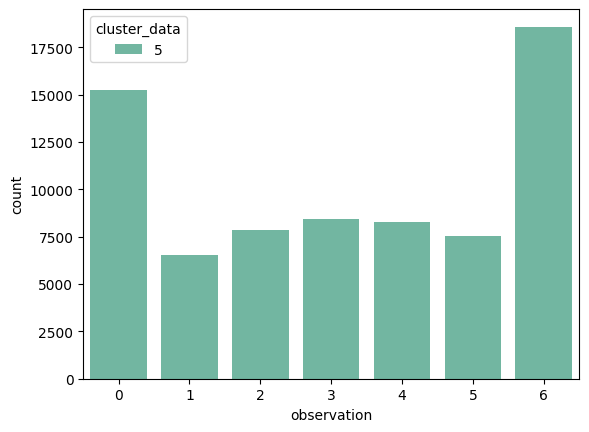

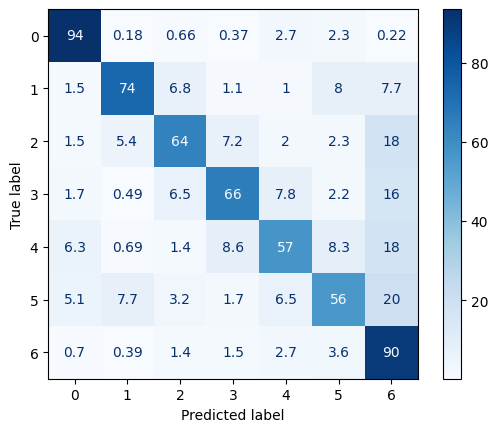

{'average_accuracy': 0.757730535615682, 'average_f1_macro': np.float64(0.7182133799927707), 'average_f1_micro': np.float64(0.757730535615682), 'average_auc': np.float64(0.9367111737487077), 'average_acc_kelas_generatif': 0.6581062518388588, 'average_acc_fase_padi': 0.6335765852138296}
{'val_accuracy': 0.7625367277316558, 'val_f1_macro': np.float64(0.7272642288467335), 'val_f1_micro': np.float64(0.7625367277316558), 'val_auc': np.float64(0.9410717167239461), 'val_acc_kelas_generatif': 0.6559959349593496, 'val_acc_fase_padi': 0.6465129100431867, 'val_relative_acc': np.float64(95.99761872052022)}
CLUSTER:  6


[I 2024-10-29 08:52:17,466] A new study created in memory with name: no-name-6636bc0a-b8ad-4c71-be9a-58b9a6f749b3


[6 2 3 5 0 4 1]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-29 08:52:33,826] Trial 0 finished with value: 0.39640731942728946 and parameters: {'max_depth': 7, 'learning_rate': 0.09764164533942185, 'reg_lambda': 3.859564342404636, 'min_child_weight': 79}. Best is trial 0 with value: 0.39640731942728946.
[I 2024-10-29 08:53:19,937] Trial 1 finished with value: 0.4017887453843187 and parameters: {'max_depth': 10, 'learning_rate': 0.03344964925162029, 'reg_lambda': 0.21870076876292321, 'min_child_weight': 67}. Best is trial 1 with value: 0.4017887453843187.
[I 2024-10-29 08:53:51,720] Trial 2 finished with value: 0.3961153786610621 and parameters: {'max_depth': 7, 'learning_rate': 0.04817735112286529, 'reg_lambda': 1.9872740487674696, 'min_child_weight': 78}. Best is trial 1 with value: 0.4017887453843187.
[I 2024-10-29 08:54:15,103] Trial 3 finished with value: 0.3958999622280636 and parameters: {'max_depth': 9, 'learning_rate': 0.07246439008672442, 'reg_lambda': 0.9328739506967708, 'min_child_weight': 97}. Best is trial 1 with value: 0

Best Parameters: {'max_depth': 10, 'learning_rate': 0.03344964925162029, 'reg_lambda': 0.21870076876292321, 'min_child_weight': 67}
Best Score: 0.4017887453843187
Start the modelling
[0]	train-mlogloss:1.92036	eval-mlogloss:1.93103
[100]	train-mlogloss:1.00626	eval-mlogloss:1.57179
[200]	train-mlogloss:0.76564	eval-mlogloss:1.54151
[300]	train-mlogloss:0.62727	eval-mlogloss:1.53153
[400]	train-mlogloss:0.51601	eval-mlogloss:1.52689
[500]	train-mlogloss:0.43247	eval-mlogloss:1.52734
[600]	train-mlogloss:0.36931	eval-mlogloss:1.52893
[700]	train-mlogloss:0.31781	eval-mlogloss:1.53118
[800]	train-mlogloss:0.27844	eval-mlogloss:1.53557
[900]	train-mlogloss:0.24433	eval-mlogloss:1.54174
[1000]	train-mlogloss:0.21713	eval-mlogloss:1.54825
[1100]	train-mlogloss:0.19221	eval-mlogloss:1.55559
[1200]	train-mlogloss:0.17301	eval-mlogloss:1.56339
[1300]	train-mlogloss:0.15743	eval-mlogloss:1.57072
[1400]	train-mlogloss:0.14397	eval-mlogloss:1.57775
[1423]	train-mlogloss:0.14097	eval-mlogloss:1.579

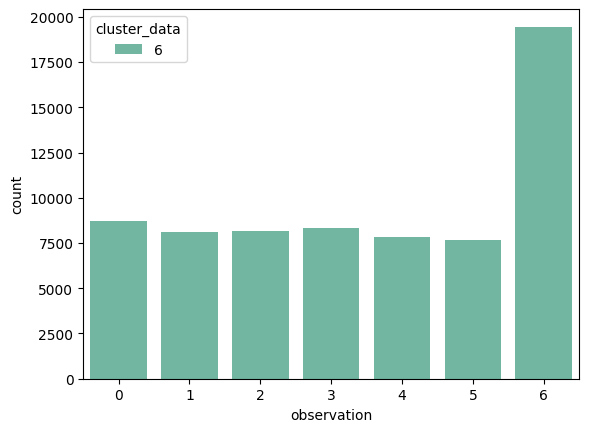

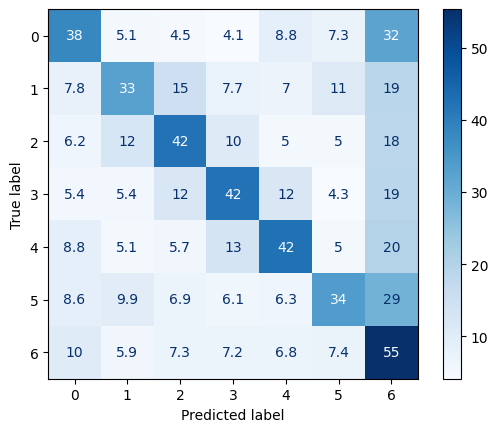

{'average_accuracy': 0.4266471449487555, 'average_f1_macro': np.float64(0.3967274842608983), 'average_f1_micro': np.float64(0.4266471449487555), 'average_auc': np.float64(0.7755490122388434), 'average_acc_kelas_generatif': 0.4039092079629709, 'average_acc_fase_padi': 0.36871821935487464}
{'val_accuracy': 0.43398870529177996, 'val_f1_macro': np.float64(0.4129981173741532), 'val_f1_micro': np.float64(0.43398870529177996), 'val_auc': np.float64(0.7919913251283814), 'val_acc_kelas_generatif': 0.42277397260273974, 'val_acc_fase_padi': 0.3993833957278133, 'val_relative_acc': np.float64(83.82265423527078)}


[500]	train-mlogloss:0.02390	eval-mlogloss:0.27078


[600]	train-mlogloss:0.01887	eval-mlogloss:0.27430


[700]	train-mlogloss:0.01578	eval-mlogloss:0.27797


[800]	train-mlogloss:0.01366	eval-mlogloss:0.28133


[900]	train-mlogloss:0.01197	eval-mlogloss:0.28445


[1000]	train-mlogloss:0.01061	eval-mlogloss:0.28750


[1100]	train-mlogloss:0.00959	eval-mlogloss:0.29045


[1200]	train-mlogloss:0.00881	eval-mlogloss:0.29305


[1300]	train-mlogloss:0.00814	eval-mlogloss:0.29563


[1331]	train-mlogloss:0.00794	eval-mlogloss:0.29639


[0]	train-mlogloss:1.72599	eval-mlogloss:1.73866


[100]	train-mlogloss:0.14330	eval-mlogloss:0.30597


[200]	train-mlogloss:0.07215	eval-mlogloss:0.27760


[300]	train-mlogloss:0.04393	eval-mlogloss:0.27394


[400]	train-mlogloss:0.03033	eval-mlogloss:0.27697


[500]	train-mlogloss:0.02290	eval-mlogloss:0.28044


[600]	train-mlogloss:0.01836	eval-mlogloss:0.28456


[700]	train-mlogloss:0.01516	eval-mlogloss:0.28875


[800]	train-mlogloss:0.01303	eval-mlogloss:0.29361


[900]	train-mlogloss:0.01131	eval-mlogloss:0.29821


[1000]	train-mlogloss:0.01005	eval-mlogloss:0.30193


[1100]	train-mlogloss:0.00909	eval-mlogloss:0.30510


[1200]	train-mlogloss:0.00832	eval-mlogloss:0.30826


[1293]	train-mlogloss:0.00777	eval-mlogloss:0.31033


[0]	train-mlogloss:1.72551	eval-mlogloss:1.73692


[50]	train-mlogloss:0.26697	eval-mlogloss:0.36822


[100]	train-mlogloss:0.16663	eval-mlogloss:0.29314


[150]	train-mlogloss:0.12112	eval-mlogloss:0.26974


[200]	train-mlogloss:0.09066	eval-mlogloss:0.25735


[250]	train-mlogloss:0.06964	eval-mlogloss:0.24980


[300]	train-mlogloss:0.05583	eval-mlogloss:0.24614


[350]	train-mlogloss:0.04624	eval-mlogloss:0.24451


[400]	train-mlogloss:0.03878	eval-mlogloss:0.24393


[450]	train-mlogloss:0.03290	eval-mlogloss:0.24404


[481]	train-mlogloss:0.02968	eval-mlogloss:0.24438



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     12816
           1       0.95      0.97      0.96     10671
           2       0.93      0.94      0.94      6606
           3       0.93      0.95      0.94     10453
           4       0.93      0.95      0.94     10836
           5       0.93      0.95      0.94      4497
           6       0.80      0.73      0.77      6666

    accuracy                           0.91     62545
   macro avg       0.91      0.91      0.91     62545
weighted avg       0.91      0.91      0.91     62545



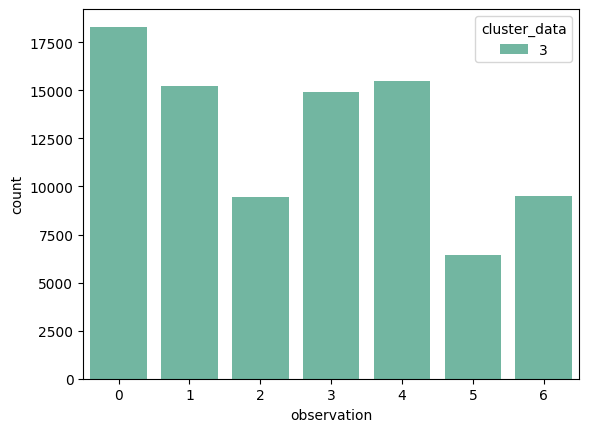

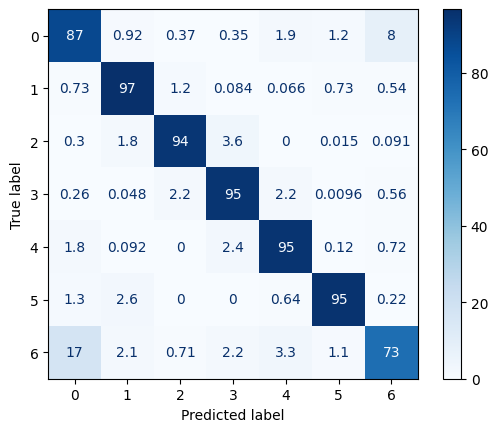

{'average_accuracy': 0.906207861359894, 'average_f1_macro': 0.9013060411749709, 'average_f1_micro': 0.906207861359894, 'average_auc': 0.9886582482324971, 'average_acc_kelas_generatif': 0.9437511899200582, 'average_acc_fase_padi': 0.9496009544056471}
{'val_accuracy': 0.9127827963866016, 'val_f1_macro': 0.9089535041023575, 'val_f1_micro': 0.9127827963866016, 'val_auc': 0.9909863400060598, 'val_acc_kelas_generatif': 0.9470965273127332, 'val_acc_fase_padi': 0.9520302857439196, 'val_relative_acc': 99.92229992229993}
CLUSTER:  4


[I 2024-10-16 17:02:38,170] A new study created in memory with name: no-name-2dbde144-557f-4130-9a88-eca4118d19b7


[0 2 1 3 4 6 5]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-16 17:04:12,569] Trial 0 finished with value: 0.9639883986506321 and parameters: {'max_depth': 6, 'learning_rate': 0.024894990849363613, 'reg_lambda': 0.9980363438478806, 'min_child_weight': 61}. Best is trial 0 with value: 0.9639883986506321.


[I 2024-10-16 17:04:49,948] Trial 1 finished with value: 0.9658529203698465 and parameters: {'max_depth': 6, 'learning_rate': 0.09978245275239626, 'reg_lambda': 1.2548875989830552, 'min_child_weight': 56}. Best is trial 1 with value: 0.9658529203698465.


[I 2024-10-16 17:06:19,334] Trial 2 finished with value: 0.9652706460733583 and parameters: {'max_depth': 9, 'learning_rate': 0.023193434565422825, 'reg_lambda': 0.8276494453725025, 'min_child_weight': 68}. Best is trial 1 with value: 0.9658529203698465.


[I 2024-10-16 17:08:12,042] Trial 3 finished with value: 0.9649660607290002 and parameters: {'max_depth': 6, 'learning_rate': 0.034792085246846495, 'reg_lambda': 3.7704369161799027, 'min_child_weight': 54}. Best is trial 1 with value: 0.9658529203698465.


[I 2024-10-16 17:09:06,638] Trial 4 finished with value: 0.9655282192659046 and parameters: {'max_depth': 8, 'learning_rate': 0.05868385083786465, 'reg_lambda': 0.8915817208569621, 'min_child_weight': 70}. Best is trial 1 with value: 0.9658529203698465.


[I 2024-10-16 17:10:02,986] Trial 5 finished with value: 0.9653318247962104 and parameters: {'max_depth': 7, 'learning_rate': 0.0626138567576201, 'reg_lambda': 2.0907816671962736, 'min_child_weight': 53}. Best is trial 1 with value: 0.9658529203698465.


[I 2024-10-16 17:11:04,956] Trial 6 finished with value: 0.966751523767003 and parameters: {'max_depth': 8, 'learning_rate': 0.05809987272179141, 'reg_lambda': 1.186729164320424, 'min_child_weight': 50}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:11:39,880] Trial 7 finished with value: 0.9655303612510369 and parameters: {'max_depth': 6, 'learning_rate': 0.0942061370232696, 'reg_lambda': 1.9261284081318397, 'min_child_weight': 67}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:12:19,210] Trial 8 finished with value: 0.9655767239032983 and parameters: {'max_depth': 6, 'learning_rate': 0.0957988405843492, 'reg_lambda': 0.2918945949474815, 'min_child_weight': 90}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:13:00,875] Trial 9 finished with value: 0.9652519486583193 and parameters: {'max_depth': 7, 'learning_rate': 0.08790848825535812, 'reg_lambda': 4.504983880513354, 'min_child_weight': 98}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:13:56,968] Trial 10 finished with value: 0.9655166943196667 and parameters: {'max_depth': 10, 'learning_rate': 0.07223022785387949, 'reg_lambda': 3.1613671013290565, 'min_child_weight': 82}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:15:24,236] Trial 11 finished with value: 0.9661847656484128 and parameters: {'max_depth': 8, 'learning_rate': 0.04099940650196007, 'reg_lambda': 1.6876694903582456, 'min_child_weight': 53}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:16:54,943] Trial 12 finished with value: 0.9662971592398654 and parameters: {'max_depth': 8, 'learning_rate': 0.04111130387495585, 'reg_lambda': 2.6356674941868503, 'min_child_weight': 50}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:18:14,368] Trial 13 finished with value: 0.9659079631942834 and parameters: {'max_depth': 8, 'learning_rate': 0.04923321286998059, 'reg_lambda': 2.892668692147892, 'min_child_weight': 79}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:18:57,593] Trial 14 finished with value: 0.9662141932151987 and parameters: {'max_depth': 9, 'learning_rate': 0.07608143826697114, 'reg_lambda': 2.5889153966055884, 'min_child_weight': 60}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:21:22,679] Trial 15 finished with value: 0.9613848576270442 and parameters: {'max_depth': 9, 'learning_rate': 0.01030811773602007, 'reg_lambda': 3.6185225912953896, 'min_child_weight': 62}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:22:24,294] Trial 16 finished with value: 0.9657023637855771 and parameters: {'max_depth': 7, 'learning_rate': 0.0483807679383628, 'reg_lambda': 2.253586439576864, 'min_child_weight': 50}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:23:05,252] Trial 17 finished with value: 0.9659923258129695 and parameters: {'max_depth': 10, 'learning_rate': 0.06977581495256693, 'reg_lambda': 0.18093962534766872, 'min_child_weight': 74}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:24:57,162] Trial 18 finished with value: 0.9661191137652295 and parameters: {'max_depth': 9, 'learning_rate': 0.03626677261157158, 'reg_lambda': 4.933504741907167, 'min_child_weight': 50}. Best is trial 6 with value: 0.966751523767003.


[I 2024-10-16 17:26:09,736] Trial 19 finished with value: 0.9656810055007004 and parameters: {'max_depth': 7, 'learning_rate': 0.05173645371349073, 'reg_lambda': 1.4655785164775275, 'min_child_weight': 63}. Best is trial 6 with value: 0.966751523767003.


Best Parameters: {'max_depth': 8, 'learning_rate': 0.05809987272179141, 'reg_lambda': 1.186729164320424, 'min_child_weight': 50}
Best Score: 0.966751523767003
Start the modelling


[0]	train-mlogloss:1.78588	eval-mlogloss:1.79410


[100]	train-mlogloss:0.05989	eval-mlogloss:0.15571


[200]	train-mlogloss:0.01978	eval-mlogloss:0.11648


[300]	train-mlogloss:0.01149	eval-mlogloss:0.10941


[400]	train-mlogloss:0.00827	eval-mlogloss:0.10704


[500]	train-mlogloss:0.00658	eval-mlogloss:0.10615


[600]	train-mlogloss:0.00558	eval-mlogloss:0.10574


[700]	train-mlogloss:0.00493	eval-mlogloss:0.10591


[800]	train-mlogloss:0.00445	eval-mlogloss:0.10598


[900]	train-mlogloss:0.00409	eval-mlogloss:0.10625


[1000]	train-mlogloss:0.00381	eval-mlogloss:0.10646


[1100]	train-mlogloss:0.00359	eval-mlogloss:0.10664


[1200]	train-mlogloss:0.00340	eval-mlogloss:0.10682


[1300]	train-mlogloss:0.00325	eval-mlogloss:0.10701


[1400]	train-mlogloss:0.00312	eval-mlogloss:0.10731


[1500]	train-mlogloss:0.00301	eval-mlogloss:0.10740


[1558]	train-mlogloss:0.00295	eval-mlogloss:0.10762


[0]	train-mlogloss:1.78472	eval-mlogloss:1.79218


[100]	train-mlogloss:0.05999	eval-mlogloss:0.15012


[200]	train-mlogloss:0.02028	eval-mlogloss:0.11274


[300]	train-mlogloss:0.01164	eval-mlogloss:0.10538


[400]	train-mlogloss:0.00828	eval-mlogloss:0.10309


[500]	train-mlogloss:0.00658	eval-mlogloss:0.10227


[600]	train-mlogloss:0.00554	eval-mlogloss:0.10229


[700]	train-mlogloss:0.00488	eval-mlogloss:0.10244


[800]	train-mlogloss:0.00440	eval-mlogloss:0.10259


[900]	train-mlogloss:0.00405	eval-mlogloss:0.10293


[1000]	train-mlogloss:0.00377	eval-mlogloss:0.10321


[1100]	train-mlogloss:0.00356	eval-mlogloss:0.10339


[1200]	train-mlogloss:0.00338	eval-mlogloss:0.10367


[1300]	train-mlogloss:0.00322	eval-mlogloss:0.10405


[1400]	train-mlogloss:0.00310	eval-mlogloss:0.10424


[1500]	train-mlogloss:0.00299	eval-mlogloss:0.10456


[1600]	train-mlogloss:0.00289	eval-mlogloss:0.10484


[1625]	train-mlogloss:0.00287	eval-mlogloss:0.10495


[0]	train-mlogloss:1.78538	eval-mlogloss:1.79093


[100]	train-mlogloss:0.06188	eval-mlogloss:0.15035


[200]	train-mlogloss:0.02108	eval-mlogloss:0.11319


[300]	train-mlogloss:0.01200	eval-mlogloss:0.10585


[400]	train-mlogloss:0.00855	eval-mlogloss:0.10413


[500]	train-mlogloss:0.00676	eval-mlogloss:0.10355


[600]	train-mlogloss:0.00569	eval-mlogloss:0.10313


[700]	train-mlogloss:0.00498	eval-mlogloss:0.10324


[800]	train-mlogloss:0.00447	eval-mlogloss:0.10336


[900]	train-mlogloss:0.00411	eval-mlogloss:0.10360


[1000]	train-mlogloss:0.00382	eval-mlogloss:0.10389


[1100]	train-mlogloss:0.00360	eval-mlogloss:0.10418


[1200]	train-mlogloss:0.00341	eval-mlogloss:0.10438


[1300]	train-mlogloss:0.00326	eval-mlogloss:0.10471


[1400]	train-mlogloss:0.00313	eval-mlogloss:0.10500


[1500]	train-mlogloss:0.00302	eval-mlogloss:0.10532


[1600]	train-mlogloss:0.00292	eval-mlogloss:0.10542


[1611]	train-mlogloss:0.00291	eval-mlogloss:0.10542


[0]	train-mlogloss:1.78359	eval-mlogloss:1.78928


[50]	train-mlogloss:0.19054	eval-mlogloss:0.26144


[100]	train-mlogloss:0.06178	eval-mlogloss:0.13962


[150]	train-mlogloss:0.03298	eval-mlogloss:0.11320


[200]	train-mlogloss:0.02166	eval-mlogloss:0.10254


[250]	train-mlogloss:0.01554	eval-mlogloss:0.09722


[300]	train-mlogloss:0.01199	eval-mlogloss:0.09444


[350]	train-mlogloss:0.00978	eval-mlogloss:0.09306


[400]	train-mlogloss:0.00825	eval-mlogloss:0.09221


[450]	train-mlogloss:0.00716	eval-mlogloss:0.09176


[500]	train-mlogloss:0.00634	eval-mlogloss:0.09157


[550]	train-mlogloss:0.00571	eval-mlogloss:0.09143


[600]	train-mlogloss:0.00521	eval-mlogloss:0.09143


[636]	train-mlogloss:0.00492	eval-mlogloss:0.09158



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     13824
           1       0.96      0.95      0.96     12382
           2       0.96      0.97      0.96      9003
           3       0.98      0.98      0.98      8310
           4       0.97      0.98      0.98      9441
           5       0.97      0.97      0.97      8912
           6       0.98      0.99      0.99     10548

    accuracy                           0.97     72420
   macro avg       0.97      0.97      0.97     72420
weighted avg       0.97      0.97      0.97     72420



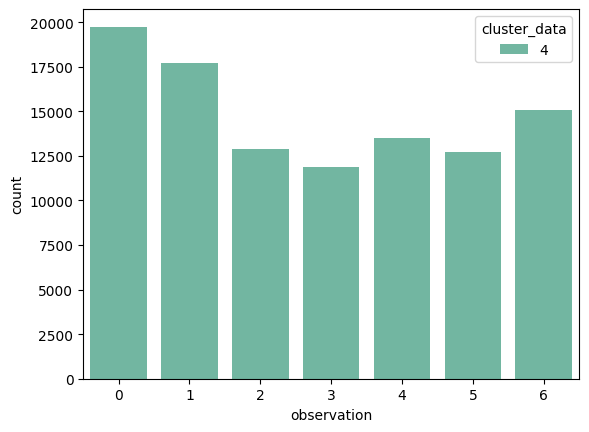

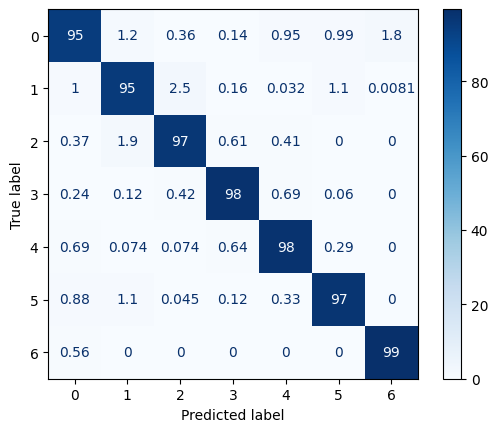

{'average_accuracy': 0.965942818623835, 'average_f1_macro': 0.9670538183098394, 'average_f1_micro': 0.965942818623835, 'average_auc': 0.998772281125114, 'average_acc_kelas_generatif': 0.9817467003650661, 'average_acc_fase_padi': 0.9673284445239373}
{'val_accuracy': 0.9693040596520298, 'val_f1_macro': 0.970398924095045, 'val_f1_micro': 0.9693040596520298, 'val_auc': 0.9990237302143079, 'val_acc_kelas_generatif': 0.9847172081829122, 'val_acc_fase_padi': 0.9696187653311529, 'val_relative_acc': 99.7799849132512}


In [27]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
df['observation']=df['observation'].apply(lambda y: int(y))
dict_report={}
for i in list(range(0,7)):
    print('=============================================================================')
    print('CLUSTER: ', i)
    df_x = df.query('cluster_data==@i')
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distplot_cluster_{i}.png", dpi=300, bbox_inches='tight')
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.7)
    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Output the unique encoded labels and the mapping
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    
    # Create an Optuna study and optimize the objective function
    print('Build Best Parameter using Optuna-Hyperparameter Tuning')
    study = optuna.create_study(direction='maximize')  # 'maximize' because we are optimizing accuracy
    study.optimize(lambda trial: objective(trial, X_train, y_train_encoded), n_trials=5)  # Run for 50 trials
    # Print the best parameters and the best score
    print(f"Best Parameters: {study.best_params}")
    print(f"Best Score: {study.best_value}")

    print('Start the modelling')
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train, y_train_encoded, X_test, y_test_encoded,cluster=i,best_params=study.best_params)
    
    dict_report[i]={'model':model0,
                    'training_metrics':training_metrics0,
                    'validation_metrics':validation_metrics0,
                    'reports':report0,
                    'cm':cm0,
                    'params':study.best_params}
    # Print the training and validation metrics
    print(training_metrics0)
    print(validation_metrics0)
    print('=============================================================================')

In [28]:
dict_report

{0: {'model': <xgboost.core.Booster at 0x7f1d10dcd8a0>,
  'training_metrics': {'average_accuracy': 0.7351140790205899,
   'average_f1_macro': np.float64(0.6997269725436405),
   'average_f1_micro': np.float64(0.7351140790205899),
   'average_auc': np.float64(0.9295883549182129),
   'average_acc_kelas_generatif': 0.8380102040816326,
   'average_acc_fase_padi': 0.650872773906983},
  'validation_metrics': {'val_accuracy': 0.7419467273260933,
   'val_f1_macro': np.float64(0.7091789001560199),
   'val_f1_micro': np.float64(0.7419467273260933),
   'val_auc': np.float64(0.9353235529443097),
   'val_acc_kelas_generatif': 0.8263483965014577,
   'val_acc_fase_padi': 0.6664782362916902,
   'val_relative_acc': np.float64(94.08720403674472)},
  'reports': '              precision    recall  f1-score   support\n\n           0       0.83      0.88      0.86     12438\n           1       0.78      0.72      0.75      4981\n           2       0.63      0.56      0.59      6310\n           3       0.83  

In [29]:
with open(f'/data/ksa/05_Modelling/model/xgboost{kdprov}_v2_new.pkl','wb') as file:
    pickle.dump(dict_report,file)

In [15]:
with open("/data/ksa/05_Modelling/model/xgboost53_v2_5+5.pkl", 'rb') as f:
    dict_report = pickle.load(f)

In [16]:
df = pd.DataFrame()
for cluster_id, metrics in dict_report.items():
    # Training metrics
    df.loc[cluster_id, 'ACCURACY'] = metrics['training_metrics']['average_accuracy']
    df.loc[cluster_id, 'F1 MACRO'] = metrics['training_metrics']['average_f1_macro']
    df.loc[cluster_id, 'F1 MICRO'] = metrics['training_metrics']['average_f1_micro']
    df.loc[cluster_id, 'AUC'] = metrics['training_metrics']['average_auc']
    df.loc[cluster_id, 'ACC [GENERATIVE]'] = metrics['training_metrics']['average_acc_kelas_generatif']
    df.loc[cluster_id, '[FASE PADI]'] = metrics['training_metrics']['average_acc_fase_padi']
    
    # Validation metrics
    df.loc[cluster_id, 'VAL ACCURACY'] = metrics['validation_metrics']['val_accuracy']
    df.loc[cluster_id, 'VAL F1 MACRO'] = metrics['validation_metrics']['val_f1_macro']
    df.loc[cluster_id, 'VAL F1 MICRO'] = metrics['validation_metrics']['val_f1_micro']
    df.loc[cluster_id, 'VAL AUC'] = metrics['validation_metrics']['val_auc']
    df.loc[cluster_id, 'VAL ACC [GENERATIVE]'] = metrics['validation_metrics']['val_acc_kelas_generatif']
    df.loc[cluster_id, 'VAL ACC [FASE PADI]'] = metrics['validation_metrics']['val_acc_fase_padi']
    df.loc[cluster_id, 'RELATIVE ACCURACY'] = metrics['validation_metrics']['val_relative_acc']

df.to_csv("Progress53.csv")

In [17]:
df

,ACCURACY,F1 MACRO,F1 MICRO,AUC,ACC [GENERATIVE],[FASE PADI],VAL ACCURACY,VAL F1 MACRO,VAL F1 MICRO,VAL AUC,VAL ACC [GENERATIVE],VAL ACC [FASE PADI],RELATIVE ACCURACY
5,0.758053,0.719125,0.758053,0.936980,0.655732,0.632290,0.762596,0.726835,0.762596,0.941196,0.656673,0.645502,96.135821
6,0.424646,0.394083,0.424646,0.774667,0.402711,0.368718,0.432106,0.412377,0.432106,0.789845,0.421233,0.401277,83.832924
